# Connect Scooters to Graph (and Warehouses)

## What you should have by now:

- nodes_final.csv - Contains all nodes of the city graph. The city graph is big enough to enclose all warehouses in the city
- edges_final.csv - The edges connecting the nodes including columns like 'gh', 'lat/lng', 'type', 'maxspeed', 'dist', 'realspeed',  'drive_time'
- a dicts folder inside the output (currently named new sol) folder. These dictionaries contain the drive times from every node to every other node (at the moment 30000^2 ~= 10^8 key value pairs)
- where_nodes_dict.csv (inside dict folder) - This dictionary contains a complete mapping of which node and its corresponding drive times is saved in which dict file.

## THESE FILES ARE REQUIRED INPUTS FOR THIS NOTEBOOK

In [1]:
# VRP
from __future__ import print_function

import pandas as pd
import numpy as np
import json
import os
import random
import overpy
import pprint
import geojson
import time
import pickle
from h3 import h3
from keplergl import KeplerGl
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

# VRP
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
def try_create_folder(folder_name: str):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return None


def aggregate_df(total: pd.DataFrame, tmp: pd.DataFrame):
    """
    Concats a new dataframe to an existing base dataframe.
    Parameters
    ----------
    total - base dataframe
    tmp - new dataframe

    Returns
    -------
    If the length of new dataframe == 0: returns base dataframe.
    If the length of new dataframe > 0 and the length of base dataframe == 0: returns the new dataframe
    If the length of new dataframe > 0 and the length of base dataframe > 0:
    returns base dataframe with the new dataframe concated to the end of the base dataframe.
    """
    if len(tmp) > 0:
        if len(total) > 0:
            total = pd.concat([total, tmp], sort=False)
        else:
            total = tmp
    return total


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat / 2) ** 2
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2)
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 1000

def apply_hav(x):
    try:
        return haversine(float(x.start_lng), float(x.start_lat), 
                         float(x.end_lng), float(x.end_lat))
    except:
        print(x.start_lng, x.start_lat, x.end_lng, x.end_lat)
        return None

## Parameters

In [3]:
input_json_name = 'routing_inputs_smol.json'

inputs_folder = 'inputs'
output_folder = 'new_sol'
dict_store = 'dicts'
plots_path = os.path.join(output_folder, 'plots')
dicts_path = os.path.join(output_folder, dict_store)
try_create_folder(output_folder)
try_create_folder(plots_path)
try_create_folder(dicts_path)

wh_df = pd.DataFrame([
    ['wh0', 52.436, 13.376],
    ['wh1', 52.561, 13.475]
], columns=['name', 'lat', 'lng'])

city_lat, city_lng = 52.52, 13.40
len_half_window = 75
reasonable_radius_margin = 0.05

realistic_speed = {
    3: 3,
    5: 5,
    6: 6,
    7: 7,
    10: 8,
    15: 13,
    17: 15,
    20: 18,
    30: 25,
    40: 33,
    50: 37,
    60: 54,
    70: 62,
    80: 71,
    100: 90,
    130: 120
}

# Berlin Bounding Box
# NW 52.6716, 13.0875
# SO 52.3923, 13.6858

## Load Scooters and Drivers from routing_inputs.json mimicking an API call

In [4]:
# # create scooters dict
# solutions_folder = '../antani_viz/data'
# with open(os.path.join(solutions_folder, 'sol_grandC.json')) as f:
#     d = json.load(f)
# routes = pd.DataFrame(d['path']).transpose().sort_values("agent").set_index("agent")
# scooters = pd.DataFrame(d['spot']).transpose().reset_index(drop=True)
# scooters = scooters[['x', 'y', 'name']].reset_index(drop=True).rename(
#     columns={'x': 'lng', 'y': 'lat', 'name': 'scooter_id'})
# scooters = scooters.assign(
#     scooter_id = scooters['scooter_id'].apply(lambda x: x[:8]))
# scooters = scooters.assign(
#     idx = scooters['scooter_id'].apply(lambda x: random.randint(100000,999999)))
# scooters = scooters.set_index("idx")
# scooters.transpose().to_json("tmp.json")

with open(os.path.join(inputs_folder, input_json_name)) as f:
    d = json.load(f)
drivers = pd.DataFrame(d['drivers']).transpose().sort_values("id").reset_index(drop=True)
scooters = pd.DataFrame(d['scooters']).transpose().reset_index(drop=True)
# get gh for each scooter
scooters = scooters.assign(gh = scooters.apply(
    lambda x: h3.geo_to_h3(float(x.lat), float(x.lng), 10), axis=1))

wh_dict = wh_df.set_index('name').transpose().to_dict()
drivers = drivers.assign(
    start_lat = drivers['start_location'].apply(lambda x: wh_dict[x]['lat']))
drivers = drivers.assign(
    start_lng = drivers['start_location'].apply(lambda x: wh_dict[x]['lng']))
drivers = drivers.assign(
    end_lat = drivers['end_location'].apply(lambda x: wh_dict[x]['lat']))
drivers = drivers.assign(
    end_lng = drivers['end_location'].apply(lambda x: wh_dict[x]['lng']))
display(drivers.head())
display(scooters.head())
print('len(drivers): %i' % len(drivers))
print('len(scooters): %i' % len(scooters))
drivers.to_csv(os.path.join(output_folder, 'drivers.csv'))

,id,start_location,end_location,start_time,end_time,capacity,type,start_lat,start_lng,end_lat,end_lng
0,0,wh0,wh0,2019-12-24 12:00:00,2019-12-24 18:00:00,3,van,52.436,13.376,52.436,13.376
1,1,wh0,wh0,2019-12-24 14:00:00,2019-12-24 18:00:00,10,bike,52.436,13.376,52.436,13.376
2,2,wh0,wh0,2019-12-24 14:00:00,2019-12-24 18:00:00,4,van,52.436,13.376,52.436,13.376


,lng,lat,scooter_id,gh
0,13.3953,52.5243,69aae7bd,8a1f1d489c8ffff
1,13.3655,52.503,eb88cbe1,8a1f1d48a387fff
2,13.3512,52.5142,da50c033,8a1f1d48a91ffff
3,13.392,52.53,c326c7af,8a1f1d489d37fff
4,13.2818,52.5894,bdceae74,8a1f1d4a1d8ffff


len(drivers): 3
len(scooters): 19


## Connect scooter locations with graph

In [5]:
def get_reasonable_window(city_lat, city_lng, len_half_window=75, verbose=False):
    """
    get reasonable window sizes
    using f.e. 75 gives you a 150 x 150 m window    
    """
    for i in range(100):
        dist = haversine(city_lat, city_lng, city_lat, city_lng + 0.0001 * i)
        if dist > len_half_window:
            break
    stretch_lat = round(0.0001 * i, 4)

    for i in range(100):
        dist = haversine(city_lat, city_lng, city_lat + 0.0001 * i, city_lng)
        if dist > len_half_window:
            break
    stretch_lng = round(0.0001 * i, 4)

    if verbose:
        print(stretch_lat, stretch_lng)

    return stretch_lat, stretch_lng


def window_node_finder(nodes, lat, lng, stretch_lat=0.0001,
                          stretch_lng=0.0001, multiplier=1):
    """
    returns idx of nodes that are within a search window given by
    stretch_lat, stretch_lng, multiplier
    """
    return nodes[
        (nodes['lat'] > lat - stretch_lat * multiplier) &
        (nodes['lat'] < lat + stretch_lat * multiplier) &
        (nodes['lng'] > lng - stretch_lng * multiplier) &
        (nodes['lng'] < lng + stretch_lng * multiplier)]


def search_closest_nodes_window(nodes, df, df_id_col='scooter_id',
                                stretch_lat=0.0001, stretch_lng=0.0001):
    """
    iterate over scooter rows and find all nodes within a small window
    if nothing is returned, try a slightly bigger window
    if still nothing is returned, save for later (gh matching)
    """
    raw_matches = []
    no_match = []
    print('search_closest_nodes_window: start window matching')
    start_time = time.time()
    for idx, row in df.iterrows():
        # get node idx within window
        idxs = window_node_finder(
            nodes, row.lat, row.lng, stretch_lat,
            stretch_lng, 1)['id'].values
        # save all indexes in raw_matches
        for idx in idxs:
            raw_matches.append([row[df_id_col], idx])
        # if no indexes were found, try again for a bigger window
        if len(idxs) == 0:
            # get node idx within bigger window (diameter 5x bigger)
            idxs = window_node_finder(
                nodes, row.lat, row.lng, stretch_lat,
                stretch_lng, 5)['id'].values
            # save all indexes in raw_matches
            for idx in idxs:
                raw_matches.append([row[df_id_col], idx])
            # if still no indexes found, append node id to no_match column
            if len(idxs) == 0:
                no_match.append(row[df_id_col])

    print('search_closest_nodes_window: window matching finished after %0.2f sec' % (
            time.time() - start_time))
    print("search_closest_nodes_window: %i matches generated for %i df" % (
        len(raw_matches), len(df)))
    print('search_closest_nodes_window: len(no_match): %i' % len(no_match))

    return raw_matches, no_match


def put_dict(d, keys, item):
    if "." in keys:
        key, rest = keys.split(".", 1)
        if key not in d:
            d[key] = {}
        put_dict(d[key], rest, item)
    else:
        d[keys] = item


def get_dict(d, keys):
    if "." in keys:
        key, rest = keys.split(".", 1)
        return get_dict(d[key], rest)
    else:
        return d[keys]


def search_closest_nodes_dict(node_dict, df, df_id_col='scooter_id',
                              no_match=[]):
    """
    generate matches by retrieving the closest geohashes for each scooter
    """
    raw_matches = []
    direct_hits = 0
    num_breaks = 0
    break_num = 50
    print('search_closest_nodes_dict: start gh dict matching calculation')
    start_time = time.time()

    # if no_match array is supplied, 
    # filter out rows in df which don't match an id from no_match
    if len(no_match) > 0:
        df = df[df[df_id_col].isin(no_match)]

    for idx, row in df.iterrows():
        gh = list(row['gh'])
        count = 0

        # iterate through geohash entries iteratively removing 
        # the last item at each iteration
        for i in range(len(gh)):
            try:
                # print(row['gh'], get_dict(node_dict, '.'.join(gh[:-i])))
                # iteratively removing the last item at each iteration
                res = get_dict(node_dict, '.'.join(gh[:-i]))

                # in case of an exact match, append id that was retrieved
                # from node_dict to the matches array
                if type(res) == int:
                    direct_hits += 1
                    print("direct hit")
                    # print(res)
                    raw_matches.append([row[df_id_col], res])
                    break
                # in case of a partial match, append the 10 first ids that were 
                # retrieved from node_dict to the matches array
                elif type(res) == dict:
                    arr = str(res).split("': ")
                    for item in arr:
                        if len(item) > 7:
                            count += 1
                            if count > break_num:
                                num_breaks += 1
                                break
                            # print(int(item.split("}")[0]))
                            raw_matches.append([row[df_id_col],
                                                int(item.split("}")[0])])
                else:
                    assert 0 == 1, "ERROR"
                if count > 10:
                    num_breaks += 1
                    break

            except KeyError as e:
                None

    print('search_closest_nodes_dict: gh dict matching finished after %0.2f sec' % (
            time.time() - start_time))
    print("search_closest_nodes_dict: %i matches generated for %i df" % (
        len(raw_matches), len(df[df[df_id_col].isin(no_match)])))
    print('search_closest_nodes_dict: direct_hits: %i, num_breaks: %i, len(df): %i' % (
        direct_hits, num_breaks, len(df[df[df_id_col].isin(no_match)])))

    return raw_matches

In [6]:
edges = pd.read_csv(os.path.join(output_folder, "edges_final.csv"), index_col=0)
nodes = pd.read_csv(os.path.join(output_folder, "nodes_final.csv"), index_col=0)


stretch_lat, stretch_lng = get_reasonable_window(
    len_half_window, True)

raw_matches_window, no_match = search_closest_nodes_window(
    nodes, scooters, 'scooter_id', stretch_lat, stretch_lng)


# recursively create a nested dictionary of all geohashes (with node ids as values)
node_dict = dict()
# put all nodes into a dict
for idx, row in nodes.iterrows():
    put_dict(node_dict, '.'.join(list(row['gh'])), row['id'])
# test with:
#     print(row['gh'], get_dict(node_dict, '.'.join(list(row['gh']))))
# print dict
# pprint.pprint(node_dict)


raw_matches = search_closest_nodes_dict(
    node_dict, scooters, 'scooter_id', no_match)


# join window matches and geohash matches together
len_raw_matches = len(raw_matches)
len_raw_matches_window = len(raw_matches_window)
raw_matches.extend(raw_matches_window)
assert len(raw_matches) == len_raw_matches + len_raw_matches_window
print("total matches: %i" % len(raw_matches))

search_closest_nodes_window: start window matching
search_closest_nodes_window: window matching finished after 0.06 sec
search_closest_nodes_window: 121 matches generated for 19 df
search_closest_nodes_window: len(no_match): 1
search_closest_nodes_dict: start gh dict matching calculation
search_closest_nodes_dict: gh dict matching finished after 0.00 sec
search_closest_nodes_dict: 50 matches generated for 1 df
search_closest_nodes_dict: direct_hits: 0, num_breaks: 2, len(df): 1
total matches: 171


mean matching distance: 81.39
median matching distance: 24.24


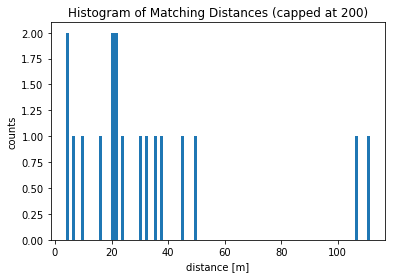

In [7]:
matches_link = pd.DataFrame(raw_matches, columns=['scooter_id', 'node_id'])

# join scooter df with matches
scooter_matched = matches_link.join(scooters.set_index('scooter_id'), on='scooter_id')
assert len(scooter_matched) == len(matches_link)

# join nodes df with matches
matched = scooter_matched.join(nodes.drop(
    columns=['gh']).set_index('id'), on='node_id', rsuffix='_node')
assert len(scooter_matched) == len(matched)

# calculate distances between scooters and nodes
dist = matched.rename(
    columns={'lng': 'start_lng', 'lat': 'start_lat', 
             'lat_node': 'end_lat', 'lng_node': 'end_lng'}).apply(
    lambda x: apply_hav(x), axis=1)
matched = matched.assign(dist = dist)
matched = matched.sort_values('dist')
scooter_nodes = matched.groupby('scooter_id').first().reset_index()

# check that scooters are not unreasonable far away from nodes
# assert sel_nodes['dist'].max() < 200

print("mean matching distance: %0.2f\nmedian matching distance: %0.2f" % (
    np.mean(scooter_nodes.dist.values),
    np.median(scooter_nodes.dist.values)))
plt.title('Histogram of Matching Distances (capped at 200)')
plt.hist(scooter_nodes.dist.values[scooter_nodes.dist.values<200], bins=100)
plt.ylabel('counts')
plt.xlabel('distance [m]')
plt.savefig(os.path.join(plots_path, 'matching_distances.png'), dpi=400)

# map_1 = KeplerGl(height=500, data={
#     'data_1': sel_nodes[sel_nodes.dist.values<200].round({'dist': 0}),
#     'nodes': nodes
# }) # , config=config
# map_1

# map_1 = KeplerGl(height=500, data={
#     'data_1': sel_nodes.round({'dist': 0}),
#     'nodes': nodes
# }) # , config=config
# map_1

## Match Warehouses to Nodes

In [8]:
raw_wh_matches_window, no_match_wh = search_closest_nodes_window(
    nodes, wh_df, 'name', stretch_lat, stretch_lng)
print('%i matches for %i warehouses' % (
    len(raw_wh_matches_window), len(wh_df)))
assert len(no_match_wh) == 0
# create wh_matches_window dataframe which maps warehouse names to node_ids
wh_matches_window = pd.DataFrame(
    raw_wh_matches_window, columns=['name', 'node_id'])
# merge lat and lng of wh_df into wh_matches_window
wh_matches_window = wh_matches_window.join(
    wh_df.set_index('name'), on='name', rsuffix='_node')

# join nodes df with matches
wh_matched = wh_matches_window.join(nodes.drop(
    columns=['gh']).set_index('id'), on='node_id', rsuffix='_node')
assert len(scooter_matched) == len(matched)

# calculate distances between scooters and nodes
dist = wh_matched.rename(
    columns={'lng': 'start_lng', 'lat': 'start_lat', 
             'lat_node': 'end_lat', 'lng_node': 'end_lng'}).apply(
    lambda x: apply_hav(x), axis=1)
wh_matched = wh_matched.assign(dist = dist)
wh_matched = wh_matched.sort_values('dist')
wh_nodes = wh_matched.groupby('name').first().reset_index()

# # visually check if the matching worked
# map_1 = KeplerGl(height=500, data={
#     'data_1': wh_matched,
#     'wh_nodes': wh_nodes,
#     'nodes': nodes
# }) # , config=config
# map_1

search_closest_nodes_window: start window matching
search_closest_nodes_window: window matching finished after 0.01 sec
search_closest_nodes_window: 86 matches generated for 2 df
search_closest_nodes_window: len(no_match): 0
86 matches for 2 warehouses


In [9]:
# append warehouse nodes to scooter nodes
scooter_wh_nodes = aggregate_df(scooter_nodes, wh_nodes.rename(columns={'name': 'scooter_id'}))

# save matched scooters
scooter_wh_nodes.to_csv(os.path.join(output_folder, "scooter_wh_nodes.csv"))

## Get all the distances between all scooters

In [10]:
scooter_wh_nodes = pd.read_csv(os.path.join(output_folder, "scooter_wh_nodes.csv"), index_col=0)

f = open(os.path.join(dicts_path, 'where_nodes_dict.csv'), "rb")
where_nodes_dict = pickle.load(f)
f.close()

In [11]:
which_files = []
for node in scooter_wh_nodes['node_id'].values:
    which_files.append([node, where_nodes_dict[node]])
which_files = pd.DataFrame(which_files, columns=['node_id', 'file_name'])
which_files = which_files.sort_values('file_name')

dist_dict = dict()
for file_name in tqdm(np.sort(which_files.file_name.unique())):
    node_ids = which_files[which_files['file_name'] == file_name]['node_id'].values

    f = open(os.path.join(dicts_path, file_name), 'rb')
    d = pickle.load(f)
    f.close()

    for nid in node_ids:
        dist_dict[nid] = d[nid]

ids_in_dict = []
for k in dist_dict.keys():
    ids_in_dict.append(k)
ids_in_dict = np.sort(np.array(ids_in_dict))

assert len(ids_in_dict) == len(np.sort(
    scooter_wh_nodes['node_id'].unique()))
assert len(np.setdiff1d(np.sort(
    scooter_wh_nodes['node_id'].values), ids_in_dict)) == 0
assert len(np.setdiff1d(ids_in_dict, np.sort(
    scooter_wh_nodes['node_id'].values))) == 0

f = open(os.path.join(dicts_path, 'dist_dict.csv'), "wb")
pickle.dump(dist_dict, f)
f.close()

In [12]:
# create the final scooters df
scooters_final = pd.merge(pd.DataFrame(scooter_nodes.groupby('node_id')['scooter_id'].apply(list)).rename(
             columns={'scooter_id': 'scooter_ids'}),
         pd.DataFrame(scooter_nodes.groupby('node_id')['scooter_id'].count()).rename(
             columns={'scooter_id': 'num_scooters'}),
         left_index=True, right_index=True)
scooters_final = pd.merge(scooters_final, scooter_nodes.groupby(
    'node_id')[['lat_node', 'lng_node']].first(),
         left_index=True, right_index=True).reset_index()

assert len(scooters) == scooters_final['num_scooters'].sum()


# create the wh scooters df
wh_nodes = wh_nodes.assign(num_scooters = 0)
wh_final = wh_nodes[
    ['node_id', 'name', 'num_scooters',
     'lat_node', 'lng_node']]

assert len(wh_df) == len(wh_final)


scooters_final.to_csv(os.path.join(output_folder, "scooters_final.csv"))
wh_final.to_csv(os.path.join(output_folder, "wh_final.csv"))

# THIS CODE IS TESTED (= it worked once on my machine)
## What you should have by now:

- scooters_final.csv - Dataframe containing the scooters matched to the nodes with the columns: node_id, scooter_ids (SOMETIMES MULTIPLE SCOOTERS PER NODE), num_scooters (= number of scooters)